In [253]:
# imports
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,Input
import random
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D

# **3. Load the mnist dataset**
***

In [254]:
# define random seed
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
keras.utils.set_random_seed(seed)
# Load and prepare the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize pixel values

# **4. Present simple statistics of this dataset:**
***

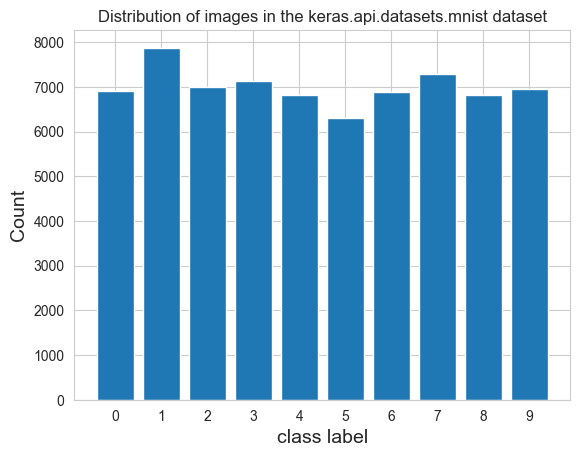

,Class distribution,Average number of white pixels,Standard deviation of white pixels,number of common non-white pixels
Digit,,,,
0,6903.0,7.240910,24.266312,345.0
1,7877.0,3.613685,10.816985,490.0
2,6990.0,5.944492,20.322924,300.0
3,7141.0,5.953368,20.555728,326.0
4,6824.0,4.847743,16.463461,316.0
5,6313.0,5.359575,18.257221,310.0
6,6876.0,5.504945,18.786060,356.0
7,7293.0,4.539284,15.439864,332.0
8,6825.0,5.555458,19.388457,350.0


In [255]:
def show_statistics(dataset):
    """
    Shows some statistics about the dataset
    :param dataset: 
    :return: 
    """
    # load the dataset
    (input_train, labels_train),(input_test,labels_test) = dataset.load_data()
     
     # combine training and test
    images = np.concatenate((input_train, input_test), axis=0)
    class_labels = np.concatenate((labels_train, labels_test), axis=0)
    
    
    # show the distribution of the images
    class_distribution = np.bincount(class_labels)
    indices = np.arange(class_distribution.size)
    plt.title(f'Distribution of images in the {dataset.__name__} dataset')
    plt.xlabel('class label', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(indices,labels=indices)
    plt.bar(indices,class_distribution)
    plt.show()
    
    # average number of white pixels(255) and their std per class
    average_white_pixels = []
    std_white_pixels = []
    common_non_white_pixels = []
    
    for digit in range(10): # 10 digits 0-9:
        digit_images = images[class_labels == digit]
        
        # columns of pixels, with consideration to RGB matrix
        white_pixels_count = np.sum(digit_images == 255, axis=(1, 2)) 
        average_white_pixels.append(np.mean(white_pixels_count))
        std_white_pixels.append(np.std(white_pixels_count))
        
        #calculate common non-white pixels- if any pixel is not 255, it is not white. 
        # sum all the areas of that along the images
        common_non_white = np.all(digit_images!= 255, axis =0).sum()     
        common_non_white_pixels.append(common_non_white)
        
    # Compile results
    statistics = {
        "Class distribution": class_distribution,
        "Average number of white pixels": average_white_pixels,
        "Standard deviation of white pixels": std_white_pixels,
        "number of common non-white pixels": common_non_white_pixels,
    }
    
    df_statistics = pd.DataFrame(statistics)
    summary_row = [np.sum(class_distribution), np.mean(average_white_pixels), np.mean(std_white_pixels), np.mean(common_non_white_pixels)]
    
    df_statistics.rename_axis('Digit', inplace=True)
    df_statistics.loc["Total Summary"] = summary_row
    display(df_statistics)
    
  
show_statistics(mnist)

**Note:** The total summary row contains the following:
* A summation of the class distribution along all classes (i.e. the total number of images in the dataset)
* An average of the average number of white pixels in each class (i.e. the average number of white pixels among all digits)
* The average standard deviation of white pixels among all digits
* The average number of common non-white pixels among all digits

# **5. Apply a simple neural network**
***


In [256]:
def multi_class_specificity(y_true, y_pred,num_classes):
    cm = confusion_matrix(y_true, y_pred)
    specificity = []
    for i in range(num_classes):
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity.append(tn / (tn + fp))
    return specificity

In [257]:
def create_classification_report(y_true,y_predicted):
    # Evaluate the model on test data
    results = classification_report(y_true, y_predicted, output_dict=True)
    not_class_specific_headers = ["accuracy","macro avg", "weighted avg"]
    class_specific_results = {key: value for key, value in results.items() if not key in not_class_specific_headers}
    
    for i in range(10):
        class_specific_results[str(i)].update({"specificity": multi_class_specificity(y_true, y_predicted,10)[i]})
        
    general_results = {key: value for key, value in results.items() if  key in not_class_specific_headers}
    general_results['macro avg'].update({"specificity":np.mean([class_specific_results[str(i)]["specificity"] for i in range(10)])})
    
    # weighted average 
    weights = np.bincount(y_test) / len(y_true) 
    general_results['weighted avg'].update({"specificity": np.sum([weights[i] * class_specific_results[str(i)]["specificity"] for i in range(10)])})
    display(Markdown("## **Accuracy**\n***"))
    display(Markdown(f"##### **Accuracy: {results['accuracy']}**"))
    display(Markdown("## **Class-specific results**\n***"))
    display(pd.DataFrame(class_specific_results))
    display(Markdown("## **Averaging results**\n***"))
    display(pd.DataFrame({key: value for key, value in general_results.items() if key != 'accuracy'}).transpose())

In [258]:
# Build the neural network model
model = Sequential([
    Input(shape=(28, 28)),  # Input layer specifying the shape of input data
    Flatten(),  # Flatten the 28x28 images to a 1D array
    Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    Dropout(0.2),  # Dropout layer to prevent overfitting
    Dense(10)  # Output layer with 10 units (one for each digit class)
])

# Compile the model with the desired metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5)

# assign the class with the highest prediction score to each image
y_prediction = tf.argmax(model.predict(x_test), axis=1)   

create_classification_report(y_test,y_prediction)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8595 - loss: 0.4914
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9537 - loss: 0.1589
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9650 - loss: 0.1161
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9725 - loss: 0.0899
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9759 - loss: 0.0767
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


## **Accuracy**
***

##### **Accuracy: 0.9761**

## **Class-specific results**
***

,0,1,2,3,4,5,6,7,8,9
precision,0.983673,0.994657,0.980354,0.968780,0.981386,0.988532,0.975181,0.962679,0.966258,0.960000
recall,0.983673,0.984141,0.967054,0.983168,0.966395,0.966368,0.984342,0.978599,0.970226,0.975223
f1-score,0.983673,0.989371,0.973659,0.975921,0.973833,0.977324,0.979740,0.970574,0.968238,0.967552
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000
specificity,0.998226,0.999323,0.997770,0.996440,0.998004,0.998902,0.997346,0.995653,0.996344,0.995440


## **Averaging results**
***

,precision,recall,f1-score,support,specificity
macro avg,0.976150,0.975919,0.975989,10000.0,0.997345
weighted avg,0.976225,0.976100,0.976117,10000.0,0.997348


For each class we calculated the following metrics:
* precision
* recall(sensitivity)
* f1-score
* support (number of samples in each class)
* specificity

It can be seen that the model performed excellently in all measures: it gained 97% accuracy, precision recall and f1-score, and 99% specificity on the test set. This can either imply overfitting or it could be that the mnist dataset is just too good to be true :)

# **6. confusion matrix**
***

In [259]:
def create_and_plot_confusion_matrix(y_true,y_predicted):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_predicted)
    display(Markdown(f"##### Confusion Matrix: \n {cm}"))
    
    # Define labels for the confusion matrix
    class_labels = [str(i) for i in range(10)]
    
    # Visualize the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

##### Confusion Matrix: 
 [[ 964    0    1    0    1    0    6    3    4    1]
 [   0 1117    4    1    0    1    3    3    6    0]
 [   2    1  998    4    3    0    3   13    7    1]
 [   0    0    2  993    0    3    0    4    2    6]
 [   1    0    2    1  949    0    4    5    2   18]
 [   3    0    0   11    2  862    4    2    4    4]
 [   2    2    0    1    3    3  943    0    4    0]
 [   1    1   10    3    0    0    0 1006    1    6]
 [   5    0    1    6    3    2    3    4  945    5]
 [   2    2    0    5    6    1    1    5    3  984]]

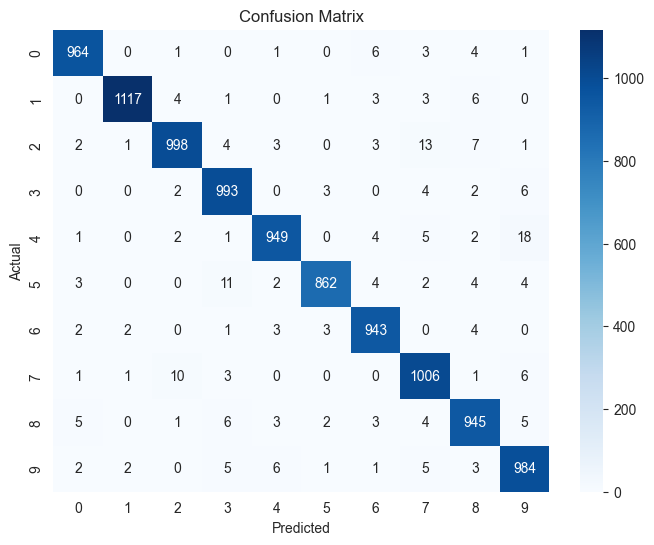

In [260]:
create_and_plot_confusion_matrix(y_test,y_prediction)

The problem we are dealing with contains 10 classes. This is a multi-class classification problem. The diagonal of this matrix, represents correct classification (0 classified as 0, 1 classified as 1 and so on...). We can see that the numbers in the diagonal are much greater than the numbers outside it. It indicates that the model did an excellent job classifying the digits correctly (we also have the classification report above with measures like: accuracy, precision, f1-score, etc. to support that statement).

# 7. **Show a figure of the Loss along the training.**
***

In [261]:
def plot_loss_graph(model_to_test,x_to_train,y_to_train,x_to_test,y_to_test):
    # Train the model and record history
    history = model_to_test.fit(x_to_train, y_to_train, epochs=20, validation_data=(x_to_test, y_to_test), verbose=0)
    
    # Plot training loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    # Find the epoch with the minimum validation loss
            # +1 since indexing starts from 0
    found_min_val_loss_epoch = np.argmin(history.history['val_loss']) + 1 
    display(Markdown(f"##### **Optimal number of epochs: {found_min_val_loss_epoch}**"))

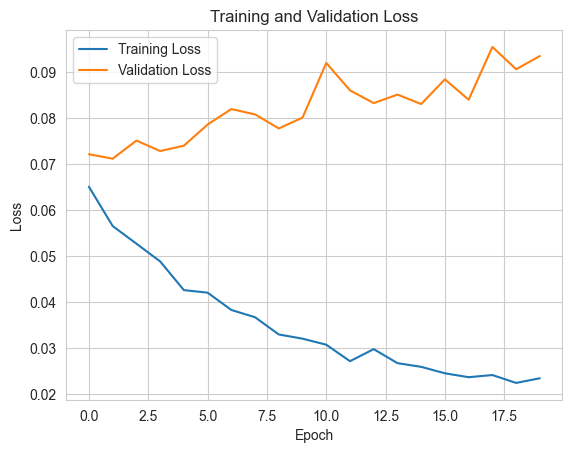

##### **Optimal number of epochs: 2**

In [262]:
plot_loss_graph(model,x_train,y_train,x_test,y_test)

It looks like the more epochs we make - the training loss is decaying, while the validation loss is increasing. This scenario demonstrates the bias-variance tradeoff. More epochs can lead to better accuracy in training, i.e. less bias, but it also may make the model more prone to over-fitting and lead to worse validation results as the variance increases and the model over-fits its training data and thus performs poorly on a new unseen data.

In [263]:
def load_mnist_images_and_labels():
    # load the dataset
    (input_train, labels_train),(input_test,labels_test) = mnist.load_data()
     
     # combine training and test
    images = np.concatenate((input_train, input_test), axis=0)
    labels = np.concatenate((labels_train, labels_test), axis=0)
    return images, labels

def build_and_compile_model(input_shape):
    # Build the neural network model
    model_to_test = Sequential([
        Input(shape=input_shape),  # Input layer specifying the shape of input data
        Flatten(),  # Flatten the 28x28 images to a 1D array
        Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
        Dropout(0.2),  # Dropout layer to prevent overfitting
        Dense(10)  # Output layer with 10 units (one for each digit class)
    ])
    
    # Compile the model with the desired metrics
    model_to_test.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model_to_test

def analyze_model_performance(x_to_train,y_to_train,x_to_test,y_to_test,input_shape):
    # Build and compile model
    model_to_test = build_and_compile_model(input_shape)
    # Train the model
    model_to_test.fit(x_to_train, y_to_train, epochs=5)
    
    # assign the class with the highest prediction score to each image
    y_predicted = tf.argmax(model_to_test.predict(x_to_test), axis=1)   
    
    display(Markdown('## **Classification report**\n***'))
    create_classification_report(y_to_test,y_predicted)
    
    display(Markdown('## **Confusion matrix**\n***'))
    create_and_plot_confusion_matrix(y_to_test,y_predicted)
    
    display(Markdown('## **Loss graph**\n***'))
    plot_loss_graph(model_to_test,x_to_train,y_to_train,x_to_test,y_to_test)

# **Step 8: Construct a New Dataset with Averaged Pixels**
***

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8563 - loss: 0.4975
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9488 - loss: 0.1734
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9602 - loss: 0.1303
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9666 - loss: 0.1106
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9706 - loss: 0.0981
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


## **Classification report**
***

## **Accuracy**
***

##### **Accuracy: 0.9732**

## **Class-specific results**
***

,0,1,2,3,4,5,6,7,8,9
precision,0.984756,0.984266,0.980431,0.963902,0.974464,0.962348,0.985201,0.950000,0.977754,0.968781
recall,0.988776,0.992070,0.970930,0.978218,0.971487,0.974215,0.972860,0.979572,0.947639,0.953419
f1-score,0.986762,0.988153,0.975657,0.971007,0.972973,0.968245,0.978992,0.964559,0.962461,0.961039
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000
specificity,0.998337,0.997970,0.997770,0.995884,0.997228,0.996267,0.998452,0.994093,0.997673,0.996552


## **Averaging results**
***

,precision,recall,f1-score,support,specificity
macro avg,0.973190,0.972919,0.972985,10000.0,0.997023
weighted avg,0.973314,0.973200,0.973188,10000.0,0.997025


## **Confusion matrix**
***

##### Confusion Matrix: 
 [[ 969    0    1    3    1    2    2    1    1    0]
 [   0 1126    2    2    0    1    2    0    2    0]
 [   2    3 1002    1    3    3    2   10    6    0]
 [   0    0    2  988    1    7    0    6    3    3]
 [   1    0    4    0  954    0    3    3    2   15]
 [   2    0    0    8    1  869    3    2    3    4]
 [   4    3    1    1    5    9  932    0    2    1]
 [   2    6    7    1    0    0    0 1007    1    4]
 [   2    0    3   14    5   11    1   11  923    4]
 [   2    6    0    7    9    1    1   20    1  962]]

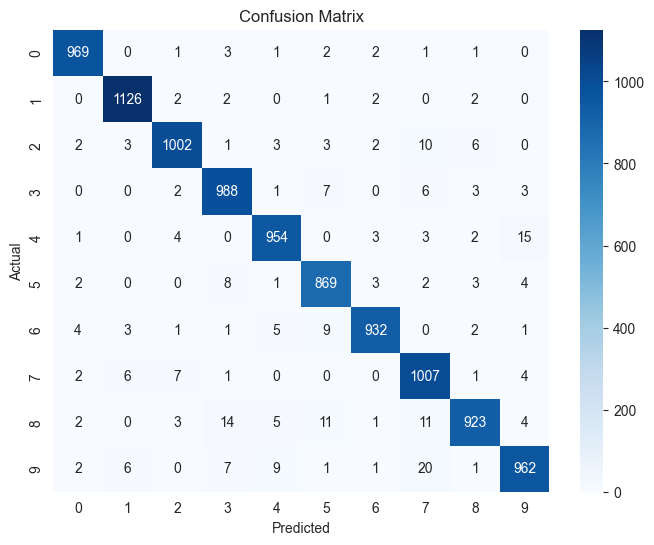

## **Loss graph**
***

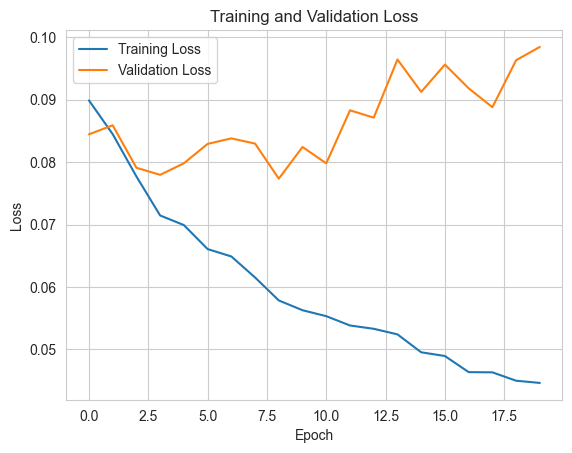

##### **Optimal number of epochs: 9**

In [264]:
def average_surrounding_pixels(images):
    # define kernel
    avg_kernel = np.ones((3, 3), np.float32) / 9
    
    # Apply convolution
    avg_images = []
    
    for image in images:
        avg_image = cv2.filter2D(image, -1, avg_kernel)
        avg_images.append(avg_image)
    return np.array(avg_images)

def split_dataset_and_normalize(dataset,labels,train_size=None,test_size=None):
    x_to_train, x_to_test, y_to_train, y_to_test = train_test_split(dataset,labels,train_size=train_size, test_size=test_size, random_state=seed)
    x_to_train, y_to_train, x_to_test, y_to_test = np.float32(x_to_train), np.int32(y_to_train), np.float32(x_to_test), np.int32(y_to_test)
    
    x_to_train, x_to_test = x_to_train / 255.0, x_to_test / 255.0  # Normalize pixel values
    return (x_to_train, y_to_train), (x_to_test, y_to_test)

# images, labels = load_mnist_images_and_labels()
averaged_images = average_surrounding_pixels(x_train)
# (x_train, y_train), (x_test, y_test) = split_dataset_and_normalize(avg_images,labels,train_size=60000,test_size=10000)
analyze_model_performance(averaged_images,y_train,x_test,y_test,(28,28))

# **9. Discuss the comparison between the results**
*** 

**Note:** In the above cell we have created a new dataset by averaging each pixel with its 9 surrounding neighbors. The averaging **does not reduce dimension** because we made sure that we keep up with the original dimensions of the images in the convolution process.
From the results we can see that:
* The accuracy of the model was slightly damaged (0.9732 Vs. 0.9761)- although, this is completely negligible.
* we could see that the same thing happens to our measures: f1_score,precision, sensitivity, specificity, etc...
* we can see that the diagonal of the confusion  matrix (correct classifications) is quite similar to the model trained on the original dataset. This is just another indication that the differences are negligible.
* Looking at the loss graph - we can see a pretty similar behaviour to the original dataset: the training loss decays as the number of epochs grows. The validation loss , However, increases as the number of epochs increases. This point can be where variance starts to grow and overcome the bias decrease that comes from making more epochs.

**The results can be explained by these bullets:**
***
* Allegedly, we would expect the averaging to denoise the images, and thus lead to higher quality training images, which will lead to better classification performance. However, three things might have occurred that may contradict that assumption:
    * The averaging process leads to an information loss. It might blur the picture, and eliminate some high-frequency components in the images (edges, differences between background and digit, etc...)- as the average kernel functions as LPF. This information loss may be the cause of degradation in the classification performance.
    * Note that we kept the original dimensions of the image while making the convolution. it requires padding, and it might be the reason why the averages perform slightly worse. Perhaps averaging with dimension reduction would have gained better performance. 
    * averaging only the training data and then checking the model performance on non-averaged, unseen images, might lead to overfitting (since we only fit the model to averaged images) which might explain this slight degradation.

# **10a: Dimension Reduction using Principal Component Analysis (PCA)**
***


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8051 - loss: 0.6840
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step - accuracy: 0.9436 - loss: 0.1948
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9573 - loss: 0.1471
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 999us/step - accuracy: 0.9644 - loss: 0.1227
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9681 - loss: 0.1082
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step


## **Classification report**
***

## **Accuracy**
***

##### **Accuracy: 0.9755**

## **Class-specific results**
***

,0,1,2,3,4,5,6,7,8,9
precision,0.976791,0.987687,0.972842,0.972387,0.987526,0.979730,0.972079,0.971680,0.963303,0.970149
recall,0.987755,0.989427,0.971899,0.976238,0.967413,0.975336,0.981211,0.967899,0.970226,0.966303
f1-score,0.982243,0.988556,0.972370,0.974308,0.977366,0.977528,0.976623,0.969786,0.966752,0.968222
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000
specificity,0.997450,0.998421,0.996878,0.996885,0.998669,0.998024,0.997014,0.996768,0.996012,0.996663


## **Averaging results**
***

,precision,recall,f1-score,support,specificity
macro avg,0.975417,0.975371,0.975376,10000.0,0.997278
weighted avg,0.975531,0.975500,0.975497,10000.0,0.997284


## **Confusion matrix**
***

##### Confusion Matrix: 
 [[ 968    0    2    1    0    1    6    1    1    0]
 [   0 1123    1    2    0    1    2    1    5    0]
 [   6    1 1003    1    2    0    3    7    9    0]
 [   0    0    7  986    0    5    0    5    4    3]
 [   2    0    3    0  950    0    5    3    2   17]
 [   2    2    0    6    0  870    5    1    4    2]
 [   5    2    0    1    3    4  940    0    3    0]
 [   2    5   12    5    0    0    1  995    1    7]
 [   4    0    3    6    2    4    4    5  945    1]
 [   2    4    0    6    5    3    1    6    7  975]]

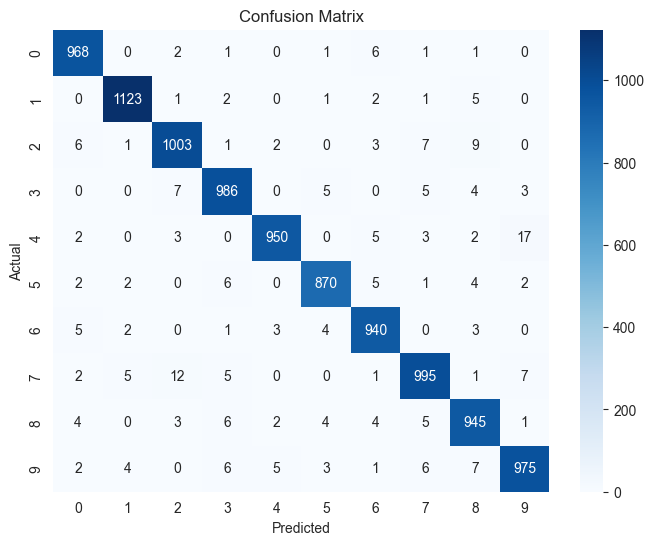

## **Loss graph**
***

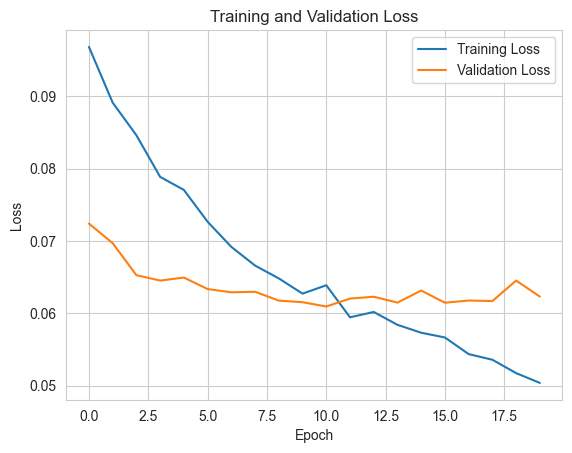

##### **Optimal number of epochs: 11**

In [265]:
# Flatten the images
X_train_flat = x_train.reshape(x_train.shape[0], -1)
X_test_flat = x_test.reshape(x_test.shape[0], -1)

# Define the number of components you want to keep
n_components = 50  # Example number, adjust based on your dataset
pca = PCA(n_components=n_components)

# Fit and transform the training data
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)
analyze_model_performance(X_train_pca,y_train,X_test_pca,y_test,(50,))

# **10b: Dimension Reduction by 3x3 Pixel Block Averaging**
***

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 941us/step - accuracy: 0.7798 - loss: 0.8426
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step - accuracy: 0.9193 - loss: 0.2802
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 968us/step - accuracy: 0.9361 - loss: 0.2155
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step - accuracy: 0.9464 - loss: 0.1812
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 991us/step - accuracy: 0.9524 - loss: 0.1593
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step


## **Classification report**
***

## **Accuracy**
***

##### **Accuracy: 0.9653**

## **Class-specific results**
***

,0,1,2,3,4,5,6,7,8,9
precision,0.973869,0.979860,0.970588,0.958580,0.968140,0.977169,0.955943,0.951149,0.954545,0.962702
recall,0.988776,0.985903,0.959302,0.962376,0.959267,0.959641,0.973904,0.965953,0.948665,0.946482
f1-score,0.981266,0.982872,0.964912,0.960474,0.963683,0.968326,0.964840,0.958494,0.951596,0.954523
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000
specificity,0.997118,0.997406,0.996655,0.995328,0.996562,0.997804,0.995244,0.994316,0.995125,0.995885


## **Averaging results**
***

,precision,recall,f1-score,support,specificity
macro avg,0.965255,0.965027,0.965099,10000.0,0.996144
weighted avg,0.965336,0.965300,0.965277,10000.0,0.996143


## **Confusion matrix**
***

##### Confusion Matrix: 
 [[ 969    0    0    1    0    2    5    1    2    0]
 [   0 1119    4    1    0    0    4    1    6    0]
 [   7    1  990    4    2    0    6   11   11    0]
 [   0    2    7  972    0    3    1   11   11    3]
 [   0    1    3    0  942    0    9    2    2   23]
 [   2    2    0   12    2  856   10    2    4    2]
 [   8    4    1    1    5    4  933    0    2    0]
 [   2    6   12    4    3    0    0  993    1    7]
 [   4    2    3    8    5    8    7   11  924    2]
 [   3    5    0   11   14    3    1   12    5  955]]

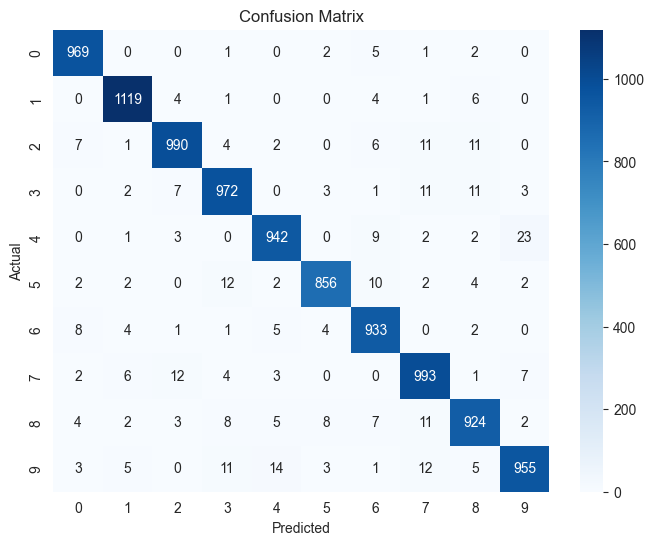

## **Loss graph**
***

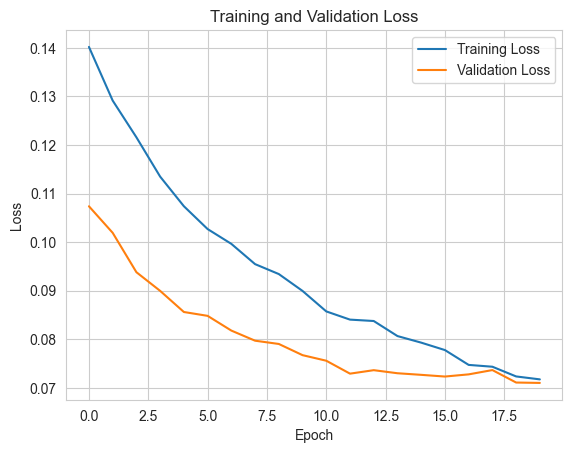

##### **Optimal number of epochs: 20**

In [275]:
def conv2d_stride_batch(images, kernel, stride):
    # Get dimensions
    batch_size, image_height, image_width = images.shape
    kernel_height, kernel_width = kernel.shape
    
    # Calculate output dimensions
    output_height = (image_height - kernel_height) // stride + 1
    output_width = (image_width - kernel_width) // stride + 1
    
    # Initialize output
    output = np.zeros((batch_size, output_height, output_width))
    
    # Perform convolution with stride for each image in the batch
    for i in range(batch_size):
        for y in range(0, output_height):
            for x in range(0, output_width):
                # Extract the region of interest
                region = images[i, y*stride:y*stride+kernel_height, x*stride:x*stride+kernel_width]
                # Perform element-wise multiplication and sum
                output[i, y, x] = np.sum(region * kernel)
    
    return output

kernel = np.ones((3, 3), np.float32) / 9
reduced_avg_images_train = conv2d_stride_batch(x_train, kernel, 3)    # to avoid over-lapping
reduced_avg_images_test = conv2d_stride_batch(x_test, kernel, 3)
analyze_model_performance(reduced_avg_images_train,y_train,reduced_avg_images_test,y_test,(9,9))

# **Create Imbalanced Dataset by Undersampling**
***

In [267]:
# Function to perform undersampling
def undersample(X, y, classes_to_undersample, target_count):
    undersampled_X, undersampled_y = [], []
    class_counts = Counter(y)

    for class_label in np.unique(y):
        class_indices = np.where(y == class_label)[0]
        if class_label in classes_to_undersample:
            sampled_indices = np.random.choice(class_indices, target_count, replace=False)
        else:
            sampled_indices = class_indices

        undersampled_X.append(X[sampled_indices])
        undersampled_y.append(y[sampled_indices])

    return np.vstack(undersampled_X), np.hstack(undersampled_y)

# Select two classes to undersample (e.g., classes 0 and 9)
classes_to_undersample = [0,9]
target_count = 500  # Number of samples for each undersampled class

X_train_undersampled, y_train_undersampled = undersample(x_train, y_train, classes_to_undersample, target_count)



print("Original class distribution:", Counter(y_train))
print("New class distribution after undersampling:", Counter(y_train_undersampled))

Original class distribution: Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
New class distribution after undersampling: Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 6: 5918, 8: 5851, 4: 5842, 5: 5421, 0: 500, 9: 500})


In [268]:
# # Build the neural network model
# OS_model = Sequential([
#     Input(shape=(28, 28)),  # Input layer specifying the shape of input data
#     Flatten(),  # Flatten the 28x28 images to a 1D array
#     Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
#     Dropout(0.2),  # Dropout layer to prevent overfitting
#     Dense(10)  # Output layer with 10 units (one for each digit class)
# ])
# 
# # Compile the model with the desired metrics
# OS_model.compile(optimizer='adam',
#                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                  metrics=['accuracy'])
# 
# # Train the model
# OS_history = OS_model.fit(X_train_undersampled, y_train_undersampled, epochs=20, validation_data=(x_test, y_test), verbose=0)
# results = OS_model.evaluate(x_test, y_test, verbose=2)
# 
# #classification
# y_prediction = tf.argmax(OS_model.predict(x_test), axis=1)
# 
# # Evaluate the model on test data
# 
# accuracy = accuracy_score(y_test, y_prediction)
# precision = precision_score(y_test, y_prediction, average='weighted')
# recall = recall_score(y_test, y_prediction, average='weighted')
# f1 = f1_score(y_test, y_prediction, average='weighted')
# 
# # Calculate Precision, Recall, and F1 Score manually
# 
# print("Accuracy score:", accuracy)
# print("Precision score:", precision)
# print("Recall (Sensitivity) score:", recall)
# print("F1 score:", f1)
# # Generate the confusion matrix
# cm = confusion_matrix(y_test, y_prediction)
# print(cm)
# 
# # Define labels for the confusion matrix
# labels = [str(i) for i in range(10)]
# 
# # Visualize the confusion matrix using seaborn
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()
# 
# # Print classification report for detailed analysis
# print(classification_report(y_test, y_prediction, target_names=labels))
# 
# # Plot training loss
# plt.plot(OS_history.history['loss'], label='Training Loss')
# plt.plot(OS_history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()
# 
# # Find the epoch with the minimum validation loss
# min_val_loss_epoch = np.argmin(OS_history.history['val_loss']) + 1
# print(f"Optimal number of epochs: {min_val_loss_epoch}")


# **Create Imbalanced Dataset by Oversampling with Image Manipulations**
***

In [269]:
# Create an image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to perform oversampling with image augmentations
def oversample_with_augmentation(X, y, classes_to_oversample, target_count):
    oversampled_X, oversampled_y = [], []
    class_counts = Counter(y)

    for class_label in np.unique(y):
        class_indices = np.where(y == class_label)[0]
        class_images = X[class_indices]

        if class_label in classes_to_oversample:
            while len(class_images) < target_count:
                augmented_images = next(datagen.flow(class_images, batch_size=target_count - len(class_images)))
                class_images = np.vstack((class_images, augmented_images))
            class_images = class_images[:target_count]

        oversampled_X.append(class_images)
        oversampled_y.append([class_label] * len(class_images))

    return np.vstack(oversampled_X), np.hstack(oversampled_y)

# Select two classes to oversample (e.g., classes 0 and 1)
classes_to_oversample = [0,9]
target_count = 10000  # Desired number of samples for each oversampled class

X_train_oversampled, y_train_oversampled = oversample_with_augmentation(x_train, y_train, classes_to_oversample, target_count)

print("Original class distribution:", Counter(y_train))
print("New class distribution after oversampling:", Counter(y_train_oversampled))


ValueError: Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape (5923, 28, 28)

In [ ]:
# Build the neural network model
OS2_model = Sequential([
    Input(shape=(28, 28)),  # Input layer specifying the shape of input data
    Flatten(),  # Flatten the 28x28 images to a 1D array
    Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    Dropout(0.2),  # Dropout layer to prevent overfitting
    Dense(10)  # Output layer with 10 units (one for each digit class)
])

# Compile the model with the desired metrics
OS2_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
OS2_history = OS2_model.fit(X_train_oversampled, y_train_oversampled, epochs=20, validation_data=(x_test, y_test), verbose=0)
results_OS2 = OS2_model.evaluate(x_test, y_test, verbose=2)

#classification
y_prediction = tf.argmax(OS2_model.predict(x_test), axis=1)

# Evaluate the model on test data

accuracy = accuracy_score(y_test, y_prediction)
precision = precision_score(y_test, y_prediction, average='weighted')
recall = recall_score(y_test, y_prediction, average='weighted')
f1 = f1_score(y_test, y_prediction, average='weighted')

# Calculate Precision, Recall, and F1 Score manually

print("Accuracy score:", accuracy)
print("Precision score:", precision)
print("Recall (Sensitivity) score:", recall)
print("F1 score:", f1)

In [ ]:
# # Generate the confusion matrix
# cm = confusion_matrix(y_test, y_prediction)
# print(cm)
# 
# # Define labels for the confusion matrix
# labels = [str(i) for i in range(10)]
# 
# # Visualize the confusion matrix using seaborn
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()
# 
# # Print classification report for detailed analysis
# print(classification_report(y_test, y_prediction, target_names=labels))
# 
# # Plot training loss
# plt.plot(OS2_history.history['loss'], label='Training Loss')
# plt.plot(OS2_history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()
# 
# # Find the epoch with the minimum validation loss
# min_val_loss_epoch = np.argmin(OS2_history.history['val_loss']) + 1
# print(f"Optimal number of epochs: {min_val_loss_epoch}")